In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import metrics
import nltk
import os
from nltk.corpus import stopwords
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mandi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [270]:
df = pd.read_csv("Outlook_mail.csv")
df.head()

,Subject,Body,Categories,Importance,Sensitivity
0,Welcome back email for Term 3 Freshmore,"Dear Cohort 2 Students,\n\n \n\nWelcome back f...",NaN,Normal,Normal
1,SC06 Group 8 HOA1 Submission,"Hi prof,\r\n\r\n Attached is ou...",NaN,Normal,Normal
2,🥋SUTD KARATE INTRO SESSION!!🥋,Hiya!\n\nReady to get a full body workout?!? P...,NaN,Normal,Normal
3,Register Now - SSIA Summit 2021 (30 Sept 2021),"Dear SUTD Community,\r\n\r\n \r\n\r\nYou are c...",NaN,Normal,Normal
4,HASS Minors Info Session,HAPPENING TODAY!\r\n\r\n \r\n\r\nDear Freshmor...,NaN,Normal,Normal


In [271]:
df['Body'] = df['Body'].apply(lambda x: x.lower())
df['Body'] = df['Body'].str.replace("[^\w\s<>]", "")
df = df.replace(r'[^0-9a-zA-Z ]', '', regex=True).replace("'", '')
df['Body'] = df['Body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
stop = stopwords.words("english") #remove useless words
df['Body'] = df['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))



print(df['Subject'])

0                Welcome back email for Term 3 Freshmore
1                           SC06 Group 8 HOA1 Submission
2                              SUTD KARATE INTRO SESSION
3            Register Now  SSIA Summit 2021 30 Sept 2021
4                               HASS Minors Info Session
                             ...                        
524    Natalie mentioned 10020 Data Driven World Fall...
525    ProjectYOU 2021  BoldWork Juraseek Playground ...
526    RE Update Postponement of Lazarus Island Dive ...
527               Update Athletics Introduction Session 
528               Summary of coverage Highlights of SUTD
Name: Subject, Length: 529, dtype: object


In [272]:
X = df['Body']
df['Importance'] = df['Importance'].str.replace("High", "1")
df['Importance'] = df['Importance'].str.replace("Normal", "1")
df['Importance'] = df['Importance'].fillna(0)
y = pd.to_numeric(df['Importance'])


print(y)

0      1
1      1
2      1
3      1
4      1
      ..
524    1
525    1
526    1
527    1
528    0
Name: Importance, Length: 529, dtype: int64


In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

In [274]:
# count every word/phrase and put it into a matrix
vect = TfidfVectorizer(ngram_range=(1,3),
                     min_df = 5,
                     max_df = 0.4,
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]+\\w*\\b')
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [275]:
# converting sparse matrices into dense matrices
# replace empty spaces in the matrices with 0 (some sentences might not have a specific word)
X_train_dense = pd.DataFrame(X_train_dtm.toarray(), columns = vect.get_feature_names())
X_test_dense = pd.DataFrame(X_test_dtm.toarray(), columns = vect.get_feature_names())
pca = PCA()
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

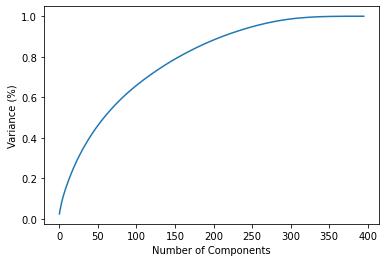

In [276]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.show()

In [277]:
pca = PCA(n_components = 200) # put a reasonable number from graph (70%-90%)
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

In [278]:
y_train

57     1
504    1
267    1
442    0
69     1
      ..
316    1
393    1
75     1
337    1
523    1
Name: Importance, Length: 396, dtype: int64

In [279]:
X_train_pca

array([[-0.07084661,  0.18832046, -0.02892269, ..., -0.00925285,
        -0.0263095 ,  0.0168122 ],
       [-0.04499115, -0.0979012 ,  0.09531842, ..., -0.02478852,
        -0.01531505, -0.00521714],
       [ 0.06866406, -0.04264973,  0.23630996, ..., -0.07769126,
         0.00074295,  0.0179292 ],
       ...,
       [-0.05412483,  0.11940273, -0.00682668, ..., -0.0351055 ,
         0.02050049, -0.04950065],
       [-0.01958647, -0.17482206,  0.06732452, ...,  0.01387475,
        -0.00058578,  0.03284146],
       [ 0.01854738, -0.05362277,  0.41790827, ..., -0.0285174 ,
        -0.04897498, -0.02350316]])

In [280]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200, criterion="entropy", n_jobs=-1, random_state=0)
rfc.fit(X_train_pca, y_train)
predictions = rfc.predict(X_test_pca)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[  0   3]
 [  0 130]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.98      1.00      0.99       130

    accuracy                           0.98       133
   macro avg       0.49      0.50      0.49       133
weighted avg       0.96      0.98      0.97       133



c:\Users\mandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [281]:
cm1 = confusion_matrix(y_test, predictions)
print("Confusion Matrix : \n", cm1)
total1 = sum(sum(cm1))

accuracy1 = (cm1[0,0] + cm1[1,1])/total1
print("Accuracy :", accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print("Sensitivity :", sensitivity1)

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print("Specificity :", specificity1)

Confusion Matrix : 
 [[  0   3]
 [  0 130]]
Accuracy : 0.9774436090225563
Sensitivity : 0.0
Specificity : 1.0


In [284]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,5),max_iter=500)
mlp.fit(X_train_pca,y_train)
y_pred_class = mlp.predict(X_test_pca)

In [285]:
cm1 = confusion_matrix(y_test,y_pred_class)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[
    
    1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[  1   2]
 [  0 130]]
Accuracy :  0.9849624060150376
Sensitivity :  0.3333333333333333
Specificity :  1.0
